<a href="https://colab.research.google.com/github/Abdulhady-Feteiha/Perfumes-recommendation-system/blob/main/Perfume_Model_Final_18_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### imports

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.contrib import layers
from tensorflow.python.estimator.inputs import numpy_io
from tensorflow.contrib.learn import *
import pickle as pkl
import sys
import re


## read data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path_csv='/content/drive/My Drive/share area/Perfumes_data/reviews_table_with_common_words_waleed.csv'
# path='/content/drive/My Drive/share area/Perfumes_data/user_data.csv'
# user_cols=[ "product_pid", "customer_id","product_rating"]
# df_raw_ratings = pd.read_csv(path_csv, usecols=user_cols) #Time_stamp not found in the data set
df_raw_ratings = pd.read_csv(path_csv) #Time_stamp not found in the data set
df_raw_ratings = df_raw_ratings.iloc[: 20471] # after this wrong data
df_raw_ratings.head(2)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


,product_pid,review_id,customer_id,customer_nickname,customer_location,customer_age,customer_gender,customer_skin,customer_eyes,number_of_days,year,month,product_rating,review_title,review_text,adore,bon,eau,aime,odeur,toilette,sent,super,belle,agréable,parfait,meilleur,produit,parfumparfum,senteur,sublime,tenue,vrai,parfumun,envoûtant,cadeau,fragrance,adoreparfum,préféré,adoreun,...,robe,original,valeur,interdit,surprise,sauvage,floral,adooore,délice,parfumeau,merveilleux,nouvelle,lasse,longue,subtil,qualité,véritable,fleuri,printemps,gourmand,élégance,caractère,incontournable,fruité,plaisir,miss,amour,satisfaite,chic,fort,douceur,rapport,cher,dommage,sens,divin,absolument,déception,délicieux,déçu
0,P3751006,129824090.0,70837926,clementine21,Paris,25to34,Female,Seche,Marrons,64.0,2019.0,6.0,5.0,Mon coup de coeur de l'été,"Pas grande amatrice de vanille d'habitude, j'a...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,P3751006,129287039.0,71723071,sarakil,paris,18to24,Female,Grasse,Marrons,80.0,2019.0,6.0,5.0,Le parfum parfait pour l'été !,j'adore le mix entre l'odeur de la mer et l'od...,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Gad's path:
path='/content/drive/My Drive/share area/Perfumes_data/sephora_products_notes_waleed-3.csv'
item_cols = ['product_pid', 'product_name', 'product_price','popularity']
#the following items('release_date', 'video_release_date', 'imdb_url') were replaced with ('product_price','product_brand','perfume_gender') along with 'popularity'

# Loading only 5 columns
df_raw_items = pd.read_csv(path, usecols=item_cols)
df_raw_items.head()

,product_name,product_pid,product_price,popularity
0,Mimosa & Cardamom - Eau De Cologne,P3153015,54.0,0.0
1,Legend Night - Eau de Parfum,P2991005,52.0,17.0
2,Legend Night - Eau de Parfum,P2991005,65.0,17.0
3,Concentré d'orange verte - Eau de Toilette,P1626026,75.0,12.0
4,ck one - Eau de Toilette,P2481,47.0,101.0


## Data preproccessing

In [ ]:
#dropping duplicates @ items dataframe because some items appear twice with the same PID which must be unique
df_raw_items.drop_duplicates(subset=['product_pid'], keep='first', inplace=True)

In [ ]:
#dropping NAN rows
df_raw_ratings = df_raw_ratings.dropna(how='any',subset=["product_pid", "customer_id","product_rating"],axis=0)
df_raw_items = df_raw_items.dropna(how='any',subset=["product_pid"],axis=0)

### assigneing new Ids for cutomer and items as the old ids are not standerdized

In [ ]:
#creating dicts to map from old to new id.
pid_keys=np.unique(df_raw_items['product_pid'].values)
pid_values=[i for i in range(len(pid_keys))]
pid_dict=dict(list(zip(pid_keys,pid_values)))

cid_keys=np.unique(df_raw_ratings['customer_id'].values)
cid_values=[i for i in range(len(cid_keys))]
cid_dict=dict(list(zip(cid_keys,cid_values)))

In [ ]:
#functions to map old id to new id
def replace_pid_with_good_one(pid_to_be_replaced):
  return pid_dict[pid_to_be_replaced]

def replace_cid_with_good_one(cid_to_be_replaced):
  return cid_dict[cid_to_be_replaced]

In [ ]:
#replacing old id with new for both customer and item dfs
df_raw_ratings['product_pid']=df_raw_ratings['product_pid'].apply(replace_pid_with_good_one)
df_raw_ratings['customer_id']=df_raw_ratings['customer_id'].apply(replace_cid_with_good_one)
df_raw_items['product_pid']=df_raw_items['product_pid'].apply(replace_pid_with_good_one)

In [ ]:
#getting total number of users and items
max_user_id=len(cid_values)
max_item_id=len(pid_values)

##STOP HERE IF YOU WANT TO USE ANY DATA USE ONE OF THOSE
df_raw_items 


df_raw_ratings 


AS THEY ARE THE PREPROCCESSED DATA 


don't import again evvvveeeeeer

In [ ]:
df_raw_ratings.head(2)

,product_pid,review_id,customer_id,customer_nickname,customer_location,customer_age,customer_gender,customer_skin,customer_eyes,number_of_days,year,month,product_rating,review_title,review_text,adore,bon,eau,aime,odeur,toilette,sent,super,belle,agréable,parfait,meilleur,produit,parfumparfum,senteur,sublime,tenue,vrai,parfumun,envoûtant,cadeau,fragrance,adoreparfum,préféré,adoreun,...,robe,original,valeur,interdit,surprise,sauvage,floral,adooore,délice,parfumeau,merveilleux,nouvelle,lasse,longue,subtil,qualité,véritable,fleuri,printemps,gourmand,élégance,caractère,incontournable,fruité,plaisir,miss,amour,satisfaite,chic,fort,douceur,rapport,cher,dommage,sens,divin,absolument,déception,délicieux,déçu
0,1580,129824090.0,10508,clementine21,Paris,25to34,Female,Seche,Marrons,64.0,2019.0,6.0,5.0,Mon coup de coeur de l'été,"Pas grande amatrice de vanille d'habitude, j'a...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1580,129287039.0,10890,sarakil,paris,18to24,Female,Grasse,Marrons,80.0,2019.0,6.0,5.0,Le parfum parfait pour l'été !,j'adore le mix entre l'odeur de la mer et l'od...,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_raw_items.head(5)

,product_name,product_pid,product_price,popularity
0,Mimosa & Cardamom - Eau De Cologne,717,54.0,0.0
1,Legend Night - Eau de Parfum,589,52.0,17.0
3,Concentré d'orange verte - Eau de Toilette,103,75.0,12.0
4,ck one - Eau de Toilette,368,47.0,101.0
6,Wood Sage & Sea Salt - Eau De Cologne,724,54.0,15.0


##getting embeddings

In [ ]:
cols= [col for col in df_raw_ratings.columns]    #read the columns from the csv
first_word_index=0                         #initalize first french word index to zero

for ind,word in enumerate(cols):
  first_word_index+=1 #increment per column (To get the column number for first french word)
  if word=="review_text": #NOTE: THIS DEPENDS ON HAVING "review_text" as the last column before the french words.
    break 
    
word_cols=cols[first_word_index:]

In [ ]:
# word_and_itemid=word_cols.copy()
# word_and_itemid.append('product_pid')
# word_and_itemid.append('review_id')

# df_raw_ratings[word_and_itemid]

In [ ]:
#For ITEMS:
word_and_itemid=word_cols.copy()
word_and_itemid.append('product_pid')
word_and_itemid.append('review_id')

# review_words_itemid_only=pd.read_csv(path_csv,usecols=word_and_itemid)
review_words_itemid_only = df_raw_ratings[word_and_itemid]
p_id_cumulative_sum=review_words_itemid_only.drop(['review_id'], axis=1).groupby('product_pid').sum()
product_count_matrix=p_id_cumulative_sum.to_numpy()
print(product_count_matrix.shape)
print(f'This means that we have {p_id_cumulative_sum.to_numpy().shape[0]} products, and {p_id_cumulative_sum.to_numpy().shape[1]} vocab words.')

#should be 1303 products and 100 vocab words

(1303, 100)
This means that we have 1303 products, and 100 vocab words.


In [ ]:
review_words_itemid_only.drop(['review_id'], axis=1).groupby('product_pid').sum()

,adore,bon,eau,aime,odeur,toilette,sent,super,belle,agréable,parfait,meilleur,produit,parfumparfum,senteur,sublime,tenue,vrai,parfumun,envoûtant,cadeau,fragrance,adoreparfum,préféré,adoreun,excellent,nouveau,merveille,coeur,pure,sensuel,bonheur,envoutant,doux,coffret,classique,mal,love,léger,découverte,...,robe,original,valeur,interdit,surprise,sauvage,floral,adooore,délice,parfumeau,merveilleux,nouvelle,lasse,longue,subtil,qualité,véritable,fleuri,printemps,gourmand,élégance,caractère,incontournable,fruité,plaisir,miss,amour,satisfaite,chic,fort,douceur,rapport,cher,dommage,sens,divin,absolument,déception,délicieux,déçu
product_pid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,1.0,5.0,1.0,3.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,2,0.0,0.0,3.0,1.0,2.0,0.0,5.0,1.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,3.0,2.0,3.0,3.0,0.0,1.0,0.0,1.0,2.0,0.0,0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,9.0,6.0,14.0,1.0,11.0,4.0,2.0,4.0,0.0,8.0,1.0,0.0,2,0.0,0.0,1.0,5.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5.0,2.0,0.0,2.0,0.0,0.0,2.0,3.0,1.0,6.0,0.0,0.0,1,0.0,1.0,2.0,1.0,2.0,0.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0,2.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,2.0
6,1.0,2.0,1.0,1.0,4.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,5.0,4.0,15.0,1.0,8.0,5.0,2.0,1.0,2.0,2.0,5.0,0.0,1,0.0,1.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,1.0,0.0,4.0,0.0,...,0.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,2,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
9,6.0,10.0,1.0,1.0,7.0,1.0,7.0,3.0,1.0,1.0,2.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1.0,7.0,2.0,2.0,6.0,2.0,7.0,6.0,0.0,2.0,0.0,1.0,0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
items_list=np.unique(review_words_itemid_only['product_pid'].tolist())
items_list.sort()

In [ ]:
#For CUSTOMERS:

word_and_custid=word_cols.copy()
word_and_custid.append('customer_id')
word_and_custid.append('review_id')

# review_words_custid_only=pd.read_csv(path_csv,usecols=word_and_custid).sort_values(by='customer_id')
review_words_custid_only = df_raw_ratings[word_and_custid]
c_id_cumulative_sum=review_words_custid_only.drop(['review_id'], axis=1).groupby('customer_id').sum()
customer_count_matrix=c_id_cumulative_sum.to_numpy()
print(customer_count_matrix.shape)
print(f'This means that we have {customer_count_matrix.shape[0]} customers, and {customer_count_matrix.shape[1]} vocab words.')

#should be 17278 products and 100 vocab words

(17278, 100)
This means that we have 17278 customers, and 100 vocab words.


In [ ]:
customers_list=np.unique(review_words_custid_only['customer_id'].tolist())
customers_list.sort()
print(f'There are, infact, {len(customers_list)} customers.')

There are, infact, 17278 customers.


In [ ]:
#ITEMS:
dict_of_counts={}
for key_num,value_list in zip(items_list, product_count_matrix):
  #debug#print(value_list)
  dict_of_counts[key_num]=value_list

#CUSTOMERS:
dict_of_counts_custs={}
for key_num,value_list in zip(customers_list, customer_count_matrix):
  #debug#print(value_list)
  dict_of_counts_custs[key_num]=value_list
  

In [ ]:
#GET INDEXED WORD EMBEDDINGS:
#waleed path
# word_embeddings_csv=pd.read_csv('/content/review_table_word2vec.csv',header=None)
# gad path:
word_embeddings_csv=pd.read_csv('/content/drive/My Drive/share area/pfembeddings/Word-embedding-NLP-generation-of-new-features-master/Word-embedding-NLP-generation-of-new-features-master/review_table_word2vec.csv',header=None)

word_embeddings_list=[]
for i in range(len(word_embeddings_csv.columns)):
  word_embeddings_list.append(word_embeddings_csv.iloc[:,i].tolist())
  #word_embeddings_list: list of lists. Each list has the word embeddings for the corresponding item.

In [ ]:
dict_of_item_embeddings={}
for key_num,value_list in zip(items_list, product_count_matrix):
  #debug#print(value_list)
  counts=value_list
  temp_embdng_list_for_this_key=np.zeros((1,len(word_embeddings_list[0])))
  for count,embdng in zip(counts,word_embeddings_list):
    temp_embdng_list_for_this_key+=count*np.array(embdng,dtype=np.float32)
  dict_of_item_embeddings[key_num]=temp_embdng_list_for_this_key

In [ ]:
print(f'Dimensions of Word Embedding are: {len(dict_of_item_embeddings[items_list[0]][0])}') #should be equal to 635
print(f'Size of of the dict of word embeddings for items is : {sys.getsizeof(dict_of_item_embeddings)} bytes.') #equal to 36968 bytes

Dimensions of Word Embedding are: 635
Size of of the dict of word embeddings for items is : 36968 bytes.


In [ ]:
#ASSERT WE ARE WORKING FINE:
#That all elements in the summed word embeddings list per item have dimensions = 635
for i in range(len(dict_of_item_embeddings.keys())):
  assert len(dict_of_item_embeddings[items_list[i]][0]) == len(word_embeddings_list[0])

In [ ]:
dict_of_customer_embeddings={} #key: customer_id #value:summerd embeddings weighted with count
for key_num,value_list in zip(customers_list, customer_count_matrix):
  #debug#print(value_list)
  counts=value_list
  temp_embdng_list_for_this_key=np.zeros((1,len(word_embeddings_list[0])))
  for count,embdng in zip(counts,word_embeddings_list): #count vector per word embedding, and word_embddings list. 
                                                            #they have corresponding order.
    temp_embdng_list_for_this_key+=count*np.array(embdng,dtype=np.float32)
  dict_of_customer_embeddings[key_num]=temp_embdng_list_for_this_key

In [ ]:
print(f'Dimensions of Word Embedding are: {len(dict_of_customer_embeddings[customers_list[0]][0])}') #should be equal to 635
import sys
print(f'Size of of the dict of word embeddings for csutomers is : {sys.getsizeof(dict_of_customer_embeddings)}')

Dimensions of Word Embedding are: 635
Size of of the dict of word embeddings for csutomers is : 589928


In [ ]:
#ASSERT WE ARE WORKING FINE:
#That all elements in the summed word embeddings list per customer have dimensions = 635
for i in range(len(dict_of_customer_embeddings.keys())):
  assert len(dict_of_customer_embeddings[customers_list[i]][0]) == len(word_embeddings_list[0])

In [ ]:
df_ratings_with_item_info = pd.merge(df_raw_items,df_raw_ratings[['customer_id','product_pid','product_rating']], how='inner', on='product_pid')
df_ratings_with_item_info.head(10)

,product_name,product_pid,product_price,popularity,customer_id,product_rating
0,Mimosa & Cardamom - Eau De Cologne,717,54.0,0.0,12767,5.0
1,Mimosa & Cardamom - Eau De Cologne,717,54.0,0.0,621,5.0
2,Mimosa & Cardamom - Eau De Cologne,717,54.0,0.0,7337,5.0
3,Legend Night - Eau de Parfum,589,52.0,17.0,10564,5.0
4,Legend Night - Eau de Parfum,589,52.0,17.0,13611,5.0
5,Legend Night - Eau de Parfum,589,52.0,17.0,13282,5.0
6,Legend Night - Eau de Parfum,589,52.0,17.0,2404,5.0
7,Legend Night - Eau de Parfum,589,52.0,17.0,1284,5.0
8,Legend Night - Eau de Parfum,589,52.0,17.0,4953,5.0
9,Legend Night - Eau de Parfum,589,52.0,17.0,795,5.0


##apply embeddings on data

In [ ]:
dict_of_item_embeddings #checking it exists.
_=0

In [ ]:
# #Create series from count per review for each item
# pid_list_to_form_embeddings=df_all_ratings['product_pid'].tolist()
# word_embedding_repeated_for_reviews=[]
# for iid in pid_list_to_form_embeddings:
#     word_embedding_repeated_for_reviews.append(list(dict_of_counts[iid])) #dict_of_item_embeddings
    
# columns_for_items_word_embeddings=["i_w_"+str(i) for i in range(len(word_cols))]

#Create series from count per review for each item
pid_list_to_form_embeddings=df_ratings_with_item_info['product_pid'].tolist()
word_embedding_repeated_for_reviews=[]
for iid in pid_list_to_form_embeddings:
    word_embedding_repeated_for_reviews.append(list(dict_of_item_embeddings[iid])[0]) #dict_of_counts
    
columns_for_items_word_embeddings=["i_w_"+str(i) for i in range(635)]

In [ ]:
df_ratings_with_item_info_and_embbeddings=df_ratings_with_item_info.join(pd.DataFrame.from_records(word_embedding_repeated_for_reviews, columns=columns_for_items_word_embeddings))

In [ ]:
df_ratings_with_item_info_and_embbeddings.head()

,product_name,product_pid,product_price,popularity,customer_id,product_rating,i_w_0,i_w_1,i_w_2,i_w_3,i_w_4,i_w_5,i_w_6,i_w_7,i_w_8,i_w_9,i_w_10,i_w_11,i_w_12,i_w_13,i_w_14,i_w_15,i_w_16,i_w_17,i_w_18,i_w_19,i_w_20,i_w_21,i_w_22,i_w_23,i_w_24,i_w_25,i_w_26,i_w_27,i_w_28,i_w_29,i_w_30,i_w_31,i_w_32,i_w_33,...,i_w_595,i_w_596,i_w_597,i_w_598,i_w_599,i_w_600,i_w_601,i_w_602,i_w_603,i_w_604,i_w_605,i_w_606,i_w_607,i_w_608,i_w_609,i_w_610,i_w_611,i_w_612,i_w_613,i_w_614,i_w_615,i_w_616,i_w_617,i_w_618,i_w_619,i_w_620,i_w_621,i_w_622,i_w_623,i_w_624,i_w_625,i_w_626,i_w_627,i_w_628,i_w_629,i_w_630,i_w_631,i_w_632,i_w_633,i_w_634
0,Mimosa & Cardamom - Eau De Cologne,717,54.0,0.0,12767,5.0,-0.412128,-0.427735,-0.426756,-0.406129,-0.398823,-0.439818,-0.418666,-0.394654,-0.422161,-0.422604,-0.416534,-0.381267,-0.422825,-0.422286,-0.43676,-0.418687,-0.410032,-0.420140,-0.423461,-0.417413,-0.427977,-0.428590,-0.435343,-0.418358,-0.424316,-0.425222,-0.115188,-0.422720,-0.411361,-0.431840,-0.436175,-0.420884,-0.424671,-0.435228,...,-0.440835,-0.407045,-0.431090,-0.422081,-0.424703,-0.438314,-0.416183,-0.428875,-0.412936,-0.424570,-0.412233,-0.411651,-0.423612,-0.430379,-0.405173,-0.414894,-0.408128,1.004439,-0.409701,-0.428707,-0.427360,-0.478392,-0.423798,-0.429703,-0.407484,-0.428721,0.427762,-0.431773,-0.418182,-0.443306,0.060740,-0.378845,-0.430134,-0.503870,-0.440235,-0.428589,-0.185871,-0.423780,-0.439254,-0.416063
1,Mimosa & Cardamom - Eau De Cologne,717,54.0,0.0,621,5.0,-0.412128,-0.427735,-0.426756,-0.406129,-0.398823,-0.439818,-0.418666,-0.394654,-0.422161,-0.422604,-0.416534,-0.381267,-0.422825,-0.422286,-0.43676,-0.418687,-0.410032,-0.420140,-0.423461,-0.417413,-0.427977,-0.428590,-0.435343,-0.418358,-0.424316,-0.425222,-0.115188,-0.422720,-0.411361,-0.431840,-0.436175,-0.420884,-0.424671,-0.435228,...,-0.440835,-0.407045,-0.431090,-0.422081,-0.424703,-0.438314,-0.416183,-0.428875,-0.412936,-0.424570,-0.412233,-0.411651,-0.423612,-0.430379,-0.405173,-0.414894,-0.408128,1.004439,-0.409701,-0.428707,-0.427360,-0.478392,-0.423798,-0.429703,-0.407484,-0.428721,0.427762,-0.431773,-0.418182,-0.443306,0.060740,-0.378845,-0.430134,-0.503870,-0.440235,-0.428589,-0.185871,-0.423780,-0.439254,-0.416063
2,Mimosa & Cardamom - Eau De Cologne,717,54.0,0.0,7337,5.0,-0.412128,-0.427735,-0.426756,-0.406129,-0.398823,-0.439818,-0.418666,-0.394654,-0.422161,-0.422604,-0.416534,-0.381267,-0.422825,-0.422286,-0.43676,-0.418687,-0.410032,-0.420140,-0.423461,-0.417413,-0.427977,-0.428590,-0.435343,-0.418358,-0.424316,-0.425222,-0.115188,-0.422720,-0.411361,-0.431840,-0.436175,-0.420884,-0.424671,-0.435228,...,-0.440835,-0.407045,-0.431090,-0.422081,-0.424703,-0.438314,-0.416183,-0.428875,-0.412936,-0.424570,-0.412233,-0.411651,-0.423612,-0.430379,-0.405173,-0.414894,-0.408128,1.004439,-0.409701,-0.428707,-0.427360,-0.478392,-0.423798,-0.429703,-0.407484,-0.428721,0.427762,-0.431773,-0.418182,-0.443306,0.060740,-0.378845,-0.430134,-0.503870,-0.440235,-0.428589,-0.185871,-0.423780,-0.439254,-0.416063
3,Legend Night - Eau de Parfum,589,52.0,17.0,10564,5.0,-0.181543,-0.220991,-0.204804,-0.204378,-0.135663,-0.209411,-0.160825,-0.168184,-0.189974,-0.219279,-0.182371,-0.112706,-0.195146,-0.189876,-0.20145,-0.255050,-0.166270,-0.213293,-0.207901,-0.187867,-0.192372,-0.196385,-0.185328,-0.170255,-0.194930,-0.185077,0.257174,-0.196477,-0.212190,-0.177533,-0.219016,-0.168559,-0.207355,-0.189879,...,-0.210092,-0.180842,-0.194119,-0.193549,-0.186625,-0.209445,-0.187831,-0.186227,-0.184733,-0.173012,-0.168177,-0.201609,-0.128117,-0.175941,-0.403867,-0.146564,-0.175307,-0.325717,-0.201492,-0.186412,-0.182978,-0.246803,-0.209228,-0.183675,-0.166391,-0.214807,0.304859,-0.202118,-0.218407,-0.217236,-1.979011,-0.136328,-0.194631,-1.474613,-0.204337,-0.200530,-0.147125,-0.183424,-0.208631,-0.239987
4,Legend Night - Eau de Parfum,589,52.0,17.0,13611,5.0,-0.181543,-0.220991,-0.204804,-0.204378,-0.135663,-0.209411,-0.160825,-0.168184,-0.189974,-0.219279,-0.182371,-0.112706,-0

In [ ]:
dict_of_customer_embeddings #checking it exists
_=0

In [ ]:
#Create series from count per review for each item
cid_list_to_form_embeddings=df_ratings_with_item_info_and_embbeddings['customer_id'].tolist()
cid_list_to_form_embeddings=[str(x) for x in cid_list_to_form_embeddings ] ## CONVERT TO STRING TO AVOID KeyError
## CONVERT TO STRING TO AVOID KeyError
## CONVERT TO STRING TO AVOID KeyError
## CONVERT TO STRING TO AVOID KeyError
## CONVERT TO STRING TO AVOID KeyError

customer_word_embedding_repeated_for_reviews=[]
for cid in cid_list_to_form_embeddings:
    customer_word_embedding_repeated_for_reviews.append(list(dict_of_customer_embeddings[int(cid)])[0]) #dict_of_counts
    
columns_for_customers_word_embeddings=["c_w_"+str(i) for i in range(635)]

In [ ]:
assert len(customer_word_embedding_repeated_for_reviews)== len(df_ratings_with_item_info_and_embbeddings)

In [ ]:
df_ratings_with_item_info_and_embbeddings=df_ratings_with_item_info_and_embbeddings.join(pd.DataFrame.from_records(customer_word_embedding_repeated_for_reviews, columns=columns_for_customers_word_embeddings))

In [ ]:
df_ratings_with_item_info_and_embbeddings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20471 entries, 0 to 20470
Columns: 1276 entries, product_name to c_w_634
dtypes: float64(1273), int64(2), object(1)
memory usage: 200.1+ MB


In [ ]:
df_ratings_with_item_info_and_embbeddings = df_ratings_with_item_info_and_embbeddings.dropna(how='any',axis=0)
df_ratings_with_item_info_and_embbeddings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19620 entries, 0 to 20470
Columns: 1276 entries, product_name to c_w_634
dtypes: float64(1273), int64(2), object(1)
memory usage: 191.2+ MB


## Train test split

In [ ]:
# Split All ratings into train_val and test
ratings_train_val, ratings_test = train_test_split(df_ratings_with_item_info_and_embbeddings, test_size=0.05, random_state=0)
# Split train_val into training and validation set
ratings_train, ratings_val = train_test_split(ratings_train_val, test_size=0.02, random_state=0)
print('Total rating rows count: {0} '.format(len(df_ratings_with_item_info_and_embbeddings))) #should be 40511
print('Total training rows count: {0} '.format(len(ratings_train_val))) #should be 32408
print('Total validation rows count: {0} '.format(len(ratings_val))) #should be 6482
print('Total test rows count: {0} '.format(len(ratings_test))) #should be 8103


Total rating rows count: 19620 
Total training rows count: 18639 
Total validation rows count: 373 
Total test rows count: 981 


In [ ]:
#normalizing meta
from sklearn.preprocessing import QuantileTransformer

meta_columns = ['popularity', 'product_price']
meta_columns.extend(columns_for_items_word_embeddings)
meta_columns.extend(columns_for_customers_word_embeddings)

scaler = QuantileTransformer()
item_meta_train = scaler.fit_transform(ratings_train[meta_columns]).astype(np.float32)
item_meta_val = scaler.transform(ratings_val[meta_columns])
item_meta_test = scaler.transform(ratings_test[meta_columns])

In [ ]:
#checking data doesn't contain NAN items
np.count_nonzero(np.isnan(item_meta_train))

0

## defining the DNN

In [ ]:
embedding_size = 450 #best: 300 )0.647 #tried: 250-700 with 50 steps #best_c: 450, 0.6216
reg_param = 0.01 #Changed from 0.01 #best: 0.005 #best_c: 0.01, 0.6216
learning_rate = 0.005 #Changed from 0.01 #best_c: 0.005, 0.6216
n_users = max_user_id + 1
n_items = max_item_id + 1
meta_size = 2 + len(columns_for_items_word_embeddings) + len(columns_for_customers_word_embeddings)


g = tf.Graph()
with g.as_default():
    
    tf.set_random_seed(1234)
    
    #creating placeholders
    users = tf.placeholder(shape=[None,1], dtype=tf.int64, name='input_users')
    items = tf.placeholder(shape=[None,1], dtype=tf.int64, name='input_items')
    meta = tf.placeholder(shape=[None,meta_size], dtype=tf.float32, name='input_metadata')
    ratings = tf.placeholder(shape=[None,1], dtype=tf.float32, name='input_ratings')
    is_training = tf.placeholder(tf.bool, None, name='is_training')

    
    l2_loss = tf.constant(0.0)
    
    # embeddding layer
    with tf.variable_scope("embedding"):
        user_weights = tf.get_variable("user_w"
                                      , shape=[n_users, embedding_size]
                                      , dtype=tf.float32
                                      , initializer=layers.xavier_initializer())
        
        item_weights = tf.get_variable("item_w"
                                       , shape=[n_items, embedding_size]
                                       , dtype=tf.float32
                                       , initializer=layers.xavier_initializer())
        
        
        
        user_embedding = tf.squeeze(tf.nn.embedding_lookup(user_weights, users),axis=1, name='user_embedding')
        item_embedding = tf.squeeze(tf.nn.embedding_lookup(item_weights, items),axis=1, name='item_embedding')
        
        l2_loss += tf.nn.l2_loss(user_weights)
        l2_loss += tf.nn.l2_loss(item_weights)
        
        
        print(user_embedding)
        print(item_embedding)
        
    
    # combine inputs
    with tf.name_scope('concatenation'):
        input_vecs = tf.concat([user_embedding, item_embedding, meta], axis=1)
        print(input_vecs)
        
    # fc-1
    num_hidden = 16 #CHANGED FROM 64, best: 32 tried: 8,15,16,28,45,64 #best_c: 16, 0.6216
    with tf.name_scope("fc_1"):
        W_fc_1 = tf.get_variable(
            "W_hidden",
            shape=[2*embedding_size + meta_size, num_hidden],
            initializer=tf.contrib.layers.xavier_initializer())
        b_fc_1 = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="b")
        hidden_output = tf.nn.relu(tf.nn.xw_plus_b(input_vecs, W_fc_1, b_fc_1), name='hidden_output')
        l2_loss += tf.nn.l2_loss(W_fc_1)
        print(hidden_output)
    
    # dropout
    with tf.name_scope("dropout"):
        h_drop = tf.nn.dropout(hidden_output, 0.9999, name="hidden_output_drop") #was 0.99 #best_c: 0.9999 #tried: 0.98,0.9,0.99,0.999
        print(h_drop)
    
    # fc-2
    with tf.name_scope("fc_2"):
        W_fc_2 = tf.get_variable(
            "W_output",
            shape=[num_hidden,1],
            initializer=tf.contrib.layers.xavier_initializer())
        b_fc_2 = tf.Variable(tf.constant(0.1, shape=[1]), name="b")
        pred = tf.nn.xw_plus_b(h_drop, W_fc_2, b_fc_2, name='pred')
        l2_loss += tf.nn.l2_loss(W_fc_2)
        print(pred)

    # loss
    with tf.name_scope("loss"):    
        loss = tf.cond(is_training , lambda: tf.nn.l2_loss(pred - ratings) + reg_param * l2_loss, lambda: tf.nn.l2_loss(pred - pred))
#         loss = tf.nn.l2_loss(pred - ratings) + reg_param * l2_loss
        train_ops = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
        rmse = tf.cond(is_training , lambda: tf.sqrt(tf.reduce_mean(tf.pow(pred - ratings, 2))), lambda: tf.sqrt(tf.reduce_mean(tf.pow(pred - pred, 2))))
#         rmse = tf.sqrt(tf.reduce_mean(tf.pow(pred - ratings, 2)))

    saver = tf.train.Saver()
        

Tensor("embedding/user_embedding:0", shape=(?, 450), dtype=float32)
Tensor("embedding/item_embedding:0", shape=(?, 450), dtype=float32)
Tensor("concatenation/concat:0", shape=(?, 2172), dtype=float32)
Tensor("fc_1/hidden_output:0", shape=(?, 16), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("dropout/hidden_output_drop/mul_1:0", shape=(?, 16), dtype=float32)
Tensor("fc_2/pred:0", shape=(?, 1), dtype=float32)


## defining Training function

In [ ]:
def train_model_deep_meta():
    

    losses_train = []
    losses_val = []
    epochs = 50 #best_c: 80


    with tf.Session(graph=g) as sess:
        sess.run(tf.global_variables_initializer())
        
        train_input_dict = {users: ratings_train['customer_id'].values.reshape([-1,1])
            , items: ratings_train['product_pid'].values.reshape([-1,1])
            , ratings: ratings_train['product_rating'].values.reshape([-1,1])
                           ,meta: item_meta_train
                           ,is_training : True} #was || meta: item_meta_train || only. no .value.reshape

        val_input_dict = {users: ratings_val['customer_id'].values.reshape([-1,1])
            , items: ratings_val['product_pid'].values.reshape([-1,1])
            , ratings: ratings_val['product_rating'].values.reshape([-1,1])
                         ,meta : item_meta_val
                         ,is_training : True} #was || meta: item_meta_train || only. no .value.reshape

        test_input_dict = {users: ratings_test['customer_id'].values.reshape([-1,1])
            , items: ratings_test['product_pid'].values.reshape([-1,1])
            , ratings: ratings_test['product_rating'].values.reshape([-1,1])
                          ,meta : item_meta_test
                          ,is_training : True} #was || meta: item_meta_train || only. no .value.reshape
        

        for i in range(epochs):
            print
            sess.run([train_ops], feed_dict=train_input_dict)
            if i % 10 == 0:
                loss_train = sess.run(loss, feed_dict=train_input_dict)
                loss_val = sess.run(loss, feed_dict=val_input_dict)
                losses_train.append(loss_train)
                losses_val.append(loss_val)
                print("iteration : %d train loss: %.3f , valid loss %.3f" % (i,loss_train, loss_val))
        
        
        # plot train and validation loss
        plt.plot(losses_train, label='train')
        plt.plot(losses_val, label='validation')
        plt.legend(loc='best')
        plt.title('Loss');
        
         # calculate RMSE on the test dataset
        print('RMSE on test dataset : {0:.4f}'.format(sess.run(rmse, feed_dict=test_input_dict)))
        save_path = tf.train.Saver().save(sess, "/content/drive/My Drive/share area/pfembeddings/model.ckpt")
        print("Model saved in file: %s" % save_path)


## Training the model

iteration : 0 train loss: 62588.547 , valid loss 1245.432
iteration : 10 train loss: 10306.393 , valid loss 342.801
iteration : 20 train loss: 4036.183 , valid loss 300.940
iteration : 30 train loss: 1680.675 , valid loss 319.243
RMSE on test dataset : 1.0911
Model saved in file: /content/drive/My Drive/share area/pfembeddings/model.ckpt


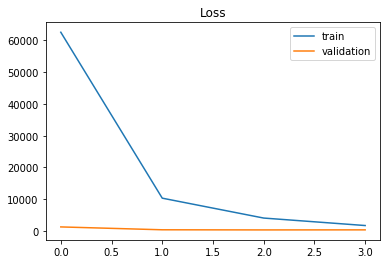

In [ ]:
train_model_deep_meta()

## defining predict function to predict rating

In [ ]:
def pred_rat(userrr,itemmm,mettt):
    #loding the model again and predicting
    with tf.Session(graph=g) as sess:
        #loading saved model
        saver = tf.train.import_meta_graph('/content/drive/My Drive/share area/pfembeddings/model.ckpt.meta')
        saver.restore(sess,tf.train.latest_checkpoint('/content/drive/My Drive/share area/pfembeddings/'))
        #creating feed dict to pass data to model
        dicttt = {users: userrr.reshape([-1,1])
            , items: itemmm.reshape([-1,1])
                          ,meta : mettt
                          ,is_training : False} #was || meta: item_meta_train || only. no .value.reshape

        # do prediction
        predicted = sess.run(pred, feed_dict=dicttt)
    return predicted

In [ ]:
def get_data_for_model_from_cust_id(old_cust_id,items_list,df_raw_items):
  
  columns_for_items_word_embeddings=["i_w_"+str(i) for i in range(635)]
  columns_for_customer_word_embeddings=["c_w_"+str(i) for i in range(635)]

  this_customer_list=[old_cust_id for x in items_list]
  this_customer_word_embedding_rows=[dict_of_customer_embeddings[old_cust_id] for x in items_list]
  all_items_word_embedding_rows=[dict_of_item_embeddings[x] for x in items_list]

  data_frame_cols=['customer_id','product_pid']
  # data_frame_cols.extend(columns_for_items_word_embeddings)
  # data_frame_cols.extend(columns_for_customer_word_embeddings)



  #datframe with columns customer_id, product_id, item_word_embeddings, customer_word_embeddings:
  this_cust_with_all_items_df=pd.DataFrame(list(zip(this_customer_list,items_list)),columns=data_frame_cols)
  all_items_word_embedding_df=pd.DataFrame(np.squeeze(np.array(all_items_word_embedding_rows)),columns=columns_for_items_word_embeddings)
  this_cust_word_embeddings_df=pd.DataFrame(np.squeeze(np.array(this_customer_word_embedding_rows)),columns=columns_for_customer_word_embeddings)

  our_merged_df=this_cust_with_all_items_df.join([all_items_word_embedding_df,this_cust_word_embeddings_df])


  item_cols = ['product_pid', 'product_name', 'product_price','product_brand','perfume_gender','popularity']
  # Loading only 5 columns
  df_items_info = df_raw_items



  our_final_merged_df = pd.merge(our_merged_df, df_items_info,on='product_pid')


  from sklearn.preprocessing import QuantileTransformer

  meta_columns = ['popularity', 'product_price']
  meta_columns.extend(columns_for_items_word_embeddings)
  meta_columns.extend(columns_for_customers_word_embeddings)

  # scaler = QuantileTransformer()
  item_meta_predict = scaler.transform(our_final_merged_df[meta_columns]).astype(np.float32)
  
  

  return our_final_merged_df['customer_id'].values,our_final_merged_df['product_pid'].values,item_meta_predict


In [ ]:
#defining function that uses get_data_for_model_from_cust_id() and pred_rat() to predict top 5 items for user with old ID (from original data set) as input
def easy_pred(useroldid):
  #creating reversed dicts to map from new ID to old id
  inverted_pid_dict = dict([[v,k] for k,v in pid_dict.items()])
  inverted_cid_dict = dict([[v,k] for k,v in cid_dict.items()])
  # print(inverted_cid_dict[useroldid])
  
  #prepare data for this user ( creat array with user and all items with embeddings to predict rating)
  cc,pp,mm = get_data_for_model_from_cust_id(cid_dict[useroldid],items_list,df_raw_items)
  #predict rating for all items
  a = pred_rat(cc,pp,mm)
  # get old (original) ids for cutomers and items instead of new ids
  cco =[inverted_cid_dict[idc] for idc in cc]
  ccp =[inverted_pid_dict[idc] for idc in pp]
  comp_out_df = pd.DataFrame({'customer_id':cco,'product_pid':ccp,'expected_rating':np.squeeze(a)})
  comp_out_df.dropna(inplace=True)
  #sort
  comp_out_df = comp_out_df.sort_values(by='expected_rating')
  return comp_out_df[-5:]


In [ ]:
#test easy_pred
easy_pred('71723071')

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/share area/pfembeddings/model.ckpt
['71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071', '71723071'

,customer_id,product_pid,expected_rating
1037,71723071,P3618022,6.622189
638,71723071,P3157137,6.635649
639,71723071,P3157141,6.636457
943,71723071,P3492110,6.726702
92,71723071,P1626012,6.937610


#Adding abdulhady's part

In [ ]:
path='/content/drive/My Drive/share area/Perfumes_data/item_data.xlsx'
item_cols = ['product_pid', 'product_name', 'notes_de_tete','note_de_coeur','note_de_fond']
df_notes = pd.read_excel(path, usecols=item_cols)

df_notes.sort_values("product_pid", inplace = True) 
  
# dropping ALL duplicte values 
df_notes.drop_duplicates(subset ="product_pid", 
                     keep = "first", inplace = True) 

In [ ]:
def splitter(notes):
#A regex based function that splits the notes cell into an array of separate notes.
  Notes=[]
  for note in notes:
    note=str(note).strip('.;')
    note_list=re.split(r'et\s*|,\s*',note)
    for n in range(len(note_list)):
      note_list[n]=note_list[n].strip()
      if n=='':
        note_list.remove(note_list[n])
      

    Notes.append(note_list)
  return Notes

In [ ]:
def most_frequent(List):
#takes a list and returns the most common element
    return max(set(List), key = List.count) 


In [ ]:
def top_finder(PIDs,df_notes,notes,top_note): 
#takes as an input the PIDs of top rated perfumes,a data frame of notes data, a list of all note lists, and the top note if already extracted, empty if not.
#It returns the top component
  top_notes=[]
  pids=[]
  for PID in PIDs:
    idx=pd.Index(df_notes['product_pid']).get_loc(PID)
    if notes[idx][0]=='nan':
      continue
    

    if top_note and top_note[0] in notes[idx]:
      
      notes[idx]=list(filter(lambda a: a !=top_note[0], notes[idx])) #remove the top note from list
      #print(top_note)
      #print(notes[idx])
      top_notes=top_notes+notes[idx]
      pids.append(PID)
    elif not top_note:
      top_notes=top_notes+notes[idx]
      
  top_note=most_frequent(sorted(top_notes)) #If there are no duplicates, it returns the first element
  return top_note,pids
  

In [ ]:
def top_comp(notes,top_note,Idxs):
  idxs=[]
  top_notes=[]
  for idx in Idxs:
    if notes[idx][0]=='nan':
      continue
    

    if top_note and top_note[0] in notes[idx]:
      
      notes[idx]=list(filter(lambda a: a !=top_note[0], notes[idx])) #remove the top note from list
      top_notes=top_notes+notes[idx]
      idxs.append(idx)
    elif not top_note:
      top_notes=top_notes+notes[idx]
      
  top_note=most_frequent(sorted(top_notes)) #If there are no duplicates, it returns the first element
  return top_note,idxs

In [ ]:
def full_note_finder(PIDs):
    tete=splitter(df_notes['notes_de_tete'])
    coeur=splitter(df_notes['note_de_coeur'])
    fond=splitter(df_notes['note_de_fond'])
    notes=[]
    for i in range(len(tete)):
      note=tete[i]+coeur[i]+fond[i]
      notes.append(note)


    top_note=[]
    try:
      first,dumb=top_finder(PIDs,df_notes,notes,top_note)
      # print('The top single component is',first)
      top_note.append(first)
      second,PIDs=top_finder(PIDs,df_notes,notes,top_note)
      # print('The top double components are',first,second)
      top_note[0]=second
      third,dumb=top_finder(PIDs,df_notes,notes,top_note)
      # print('The top triple components are',first,second,third)
      return first,second,third
    except:
      print('The inputted perfumes have no components! Outptting popular components in all perfumes:')
      Idxs=range(len(notes))
      first,dumb=top_comp(notes,top_note,Idxs)
      # print('The top single component is',first)
      top_note.append(first)
      second,Idxs=top_comp(notes,top_note,Idxs)
      # print('The top double components are',first,second)
      top_note[0]=second
      third,dumb=top_comp(notes,top_note,Idxs)
      # print('The top triple components are',first,second,third)
      return first,second,third



In [ ]:
# PIDs=['P1626001','P1626007','P1626008','P1626009','P1626017'] # a PIDs list of perfumes with components
# a,b,c = full_note_finder(PIDs)
# print(a,b,c)

Orange Patchouli Ylang-ylang


# Final function to predict notes for specific user

In [ ]:
def final_note_predict(useID): 
  """
  userID: string with original user ID (before changing or anything)
  output: predicted notes
  """
  mydf = easy_pred(useID)
  return full_note_finder(mydf['product_pid'].values)

In [ ]:
final_note_predict('70837926')

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/share area/pfembeddings/model.ckpt


('Magnolia essence', 'Bois Blonds', 'Nectarine')